# Gold prices with LSTM neural network

## Objective 

Gold has been an object of people's desire for millenia. Due to its unique color, plasticity, and non-reactivity, it was used for production of jewelry and currency, emphasizing a status of the owner. In more recent times, it found application in electronics due to its conductivity properties.

Gold has always been valuable, but it's market price constantly changes and fluctuates. In this work, we construct a long short term memory (LSTM) neural network to forecast gold prices on the morning biding session based on the recent price values.

## Description of data set

The data set contains a time series of historical gold prices in London Bullion Market Association (LBMA).
The prices are expressed in USD per troy ounce.
In this analysis, we focus on morning (AM) biding prices.
We retrieved data on 2022/01/23 from [Nasdaq](https://data.nasdaq.com/data/LBMA/GOLD) using [Nasdaq Data Link Python Client](https://github.com/Nasdaq/data-link-python) technology platform.

In [1]:
# These are main libraries we use to preprocess and visualize data.

import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
# Retrieve data from CVS file
data = pd.read_csv("./LBMA-GOLD.csv", usecols=[0, 1], index_col=0)
data.rename(columns = {'USD (AM)': 'AM'}, inplace=True)

In [3]:
# Time stamps
data.index = pd.to_datetime(data.index)
data.sort_index(inplace=True)
data.index

DatetimeIndex(['1968-01-02', '1968-01-03', '1968-01-04', '1968-01-05',
               '1968-01-08', '1968-01-09', '1968-01-10', '1968-01-11',
               '1968-01-12', '1968-01-15',
               ...
               '2022-01-10', '2022-01-11', '2022-01-12', '2022-01-13',
               '2022-01-14', '2022-01-17', '2022-01-18', '2022-01-19',
               '2022-01-20', '2022-01-21'],
              dtype='datetime64[ns]', name='Date', length=13664, freq=None)

In [4]:
# Features
data.columns

Index(['AM'], dtype='object')

The data set contains one index column ("Date") and one feature column -- gold price on the morning session.

In [5]:
# Sample of data from the top of the table
data.head()

,AM
Date,
1968-01-02,35.18
1968-01-03,35.16
1968-01-04,35.14
1968-01-05,35.14
1968-01-08,35.14


In [6]:
# Sample of data from the bottom of the table
data.tail(7)

,AM
Date,
2022-01-13,1822.40
2022-01-14,1822.25
2022-01-17,1820.05
2022-01-18,1810.80
2022-01-19,1817.50
2022-01-20,1836.70
2022-01-21,1834.25


In [7]:
first_day = min(data.index)
last_day = max(data.index)
print(f"Between {first_day} and {last_day}, we have {(last_day-first_day)}.")
print(f"Data set contains {len(data.index)} observations.")

Between 1968-01-02 00:00:00 and 2022-01-21 00:00:00, we have 19743 days 00:00:00.
Data set contains 13664 observations.


The datas set contains prices from Monday to Friday as LBMA does not work on weekends.
We assume that gold price on Friday is fixed.
Thus, we fill missing weekend values with Friday's prices.

In [8]:
# Create full date range
new_date = pd.date_range(start=min(data.index), end=max(data.index))
# Reindex old data
data = data.reindex(index=new_date)
# Fill NaN values on Saturdays and Sundays
data.AM.fillna(method="pad", inplace=True)
data

,AM
1968-01-02,35.18
1968-01-03,35.16
1968-01-04,35.14
1968-01-05,35.14
1968-01-06,35.14
...,...
2022-01-17,1820.05
2022-01-18,1810.80
2022-01-19,1817.50
2022-01-20,1836.70


In [9]:
# Create a function to plot a sequence plot
import matplotlib.pyplot as plt
%matplotlib inline

def run_sequence_plot(x, y, xlabel="year", ylabel="price per troy ounce [USD]", linestyle="y-", label=""):
    plt.plot(x, y, linestyle, label=label)
    plt.title("Gold prices over time")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.3);

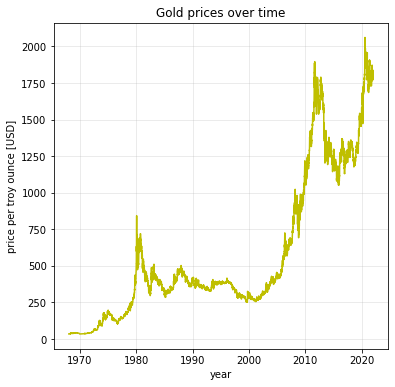

In [10]:
plt.rcParams["figure.figsize"] = [6, 6]
run_sequence_plot(data.index, data["AM"], label="real")

As we see in the plot "Gold prices over time", this time series does not look stationary. It has a clear trend and autocorrelated structure.

In [11]:
import statsmodels.api as sm

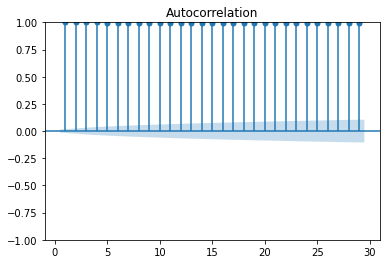

In [12]:
plt.rcParams["figure.figsize"] = [6, 4]
fig = sm.tsa.graphics.plot_acf(data.AM, lags=range(1, 30), alpha=0.05, title = 'Autocorrelation')

/opt/homebrew/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


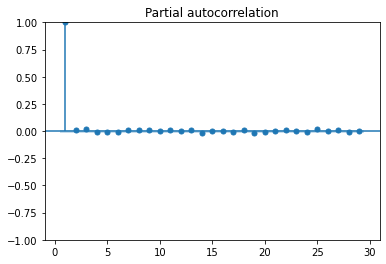

In [13]:
fig = sm.tsa.graphics.plot_pacf(data.AM, lags=range(1,30), alpha=0.05, title = 'Partial autocorrelation')

Autocorrelation and partial autocorrelation plot confirm that data is not stationary and highly correlated with itself.

<AxesSubplot:ylabel='AM'>

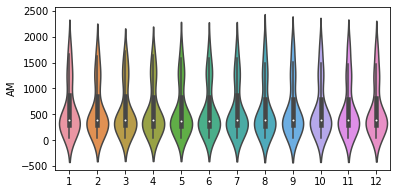

In [14]:
# Plot mean price distributions in a given month
data_monthly = data.resample("M").mean()
plt.rcParams["figure.figsize"] = [6, 3]
sns.violinplot(x=data_monthly.index.month, y=data_monthly["AM"])

We do not see any clear monthly seasonality.

<AxesSubplot:ylabel='AM'>

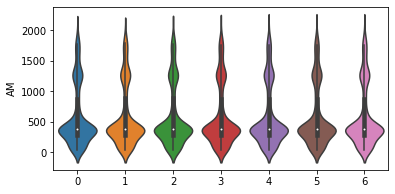

In [15]:
# Plot mean price distributions in a given day of a week
data_weekly = data#.resample("W").mean()
plt.rcParams["figure.figsize"] = [6, 3]
sns.violinplot(x=data_weekly.index.dayofweek, y=data_weekly["AM"])

We do not observe weekly seasonality.

## Data preprocessing

On the beginning, we filled missing values using previous values. Now, we scale prices using min-max method.

In [16]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()

y_scaled = mm.fit_transform(data)
data_scaled = data.copy()
data_scaled["AM"] = y_scaled[:, 0]
data_scaled

,AM
1968-01-02,0.000202
1968-01-03,0.000192
1968-01-04,0.000183
1968-01-05,0.000183
1968-01-06,0.000183
...,...
2022-01-17,0.880867
2022-01-18,0.876303
2022-01-19,0.879609
2022-01-20,0.889082


## Pedicting future values with a recurrent neural network



In [17]:
# Useful functions

def get_n_last_days(df, series_name, n_days):
    """
    Extract last n_days of an hourly time series
    """
    
    return df[series_name][-(n_days):] 

def get_keras_format_series(series):
    """
    Convert a series to a numpy array of shape 
    [n_samples, time_steps, features]
    """
    
    series = np.array(series)
    print(f"We have {series.shape[0]} samples, {series.shape[1]} time steps each, and 1 feature.")
    return series.reshape(series.shape[0], series.shape[1], 1)

def get_train_test_data(
    df, series_name, series_days, input_days, test_days=1, sample_gap=17):
    """
    Utility processing function that splits an daily time series into 
    train and test with keras-friendly format, according to user-specified
    choice of shape.    
    
    arguments
    ---------
    df (dataframe): dataframe with time series columns
    series_name (string): column name in df
    series_days (int): total days to extract
    input_days (int): length of sequence input to network 
    test_days (int): length of held-out terminal sequence
    sample_gap (int): step size between start of train sequences; default 5
    
    returns
    ---------
    tuple: train_X, test_X_init, train_y, test_y     
    """
    
    forecast_series = get_n_last_days(df, series_name, series_days).values # reducing our forecast series to last n days

    train = forecast_series[:-test_days] # training data is remaining days until amount of test_days
    test = forecast_series[-test_days:] # test data is the remaining test_days

    train_X, train_y = [], []

    # range 0 through # of train samples - input_hours by sample_gap. 
    # This is to create many samples with corresponding
    for i in range(0, train.shape[0] - input_days, sample_gap): 
        train_X.append(train[i : i+input_days]) # each training sample is of length input days
        train_y.append(train[i + input_days]) # each y is just the next step after training sample

    train_X = get_keras_format_series(train_X) # format our new training set to keras format
    train_y = np.array(train_y) # make sure y is an array to work properly with keras
    
    # The set that we had held out for testing (must be same length as original train input)
    test_X_init = test[:input_days].reshape(1, -1, 1)
    test_y = test[input_days:] # test_y is remaining values from test set
    
    return train_X, test_X_init, train_y, test_y

In [18]:
# Test and training data samples
series_days = len(data)
input_days = 31
test_days = 31 * 6
sample_gap = 13

train_X, test_X, train_y, test_y = (
    get_train_test_data(
        data_scaled, 'AM', series_days, input_days, test_days, sample_gap=sample_gap
        )
    )
print("Training X shape: ", train_X.shape)
print("Training y shape: ", train_y.shape)
print("Test X shape: ", test_X.shape)
print("Test y shape: ", test_y.shape)

We have 1503 samples, 31 time steps each, and 1 feature.
Training X shape:  (1503, 31, 1)
Training y shape:  (1503,)
Test X shape:  (1, 31, 1)
Test y shape:  (155,)


In [19]:
# We import Keras library and its crucial elements

import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
from sklearn.metrics import mean_squared_error

In [20]:
def fit_LSTM(train_X, train_y, cell_units, epochs, dropout=0.0):
    """
    Fit LSTM to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for LSTM cells  
    epochs (int): number of training epochs   
    """
    
    # initialize model
    model = Sequential() 
    
    # construct a LSTM layer with specified number of hidden units
    # per cell and desired sequence input format
    model.add(LSTM(cell_units, input_shape=(train_X.shape[1], 1))) #,return_sequences= True))
    #model.add(LSTM(cell_units, input_shape=(train_X.shape[1], 1)))
    
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(train_X, train_y, epochs=epochs, batch_size=128, verbose=1)
    loss = history.history["loss"]
    
    return model, loss

In [21]:
plt.rcParams["figure.figsize"] = [8, 10]

def predict(X_init, n_steps, model):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series      
    """
    
    X_init = X_init.copy()#.reshape(1, -1, 1)
    preds = []
    
    # iteratively take current input sequence, generate next step pred,
    # and shift input sequence forward by a step (to end with latest pred).
    # collect preds as we go.
    for _ in range(n_steps):
        pred = model.predict(X_init)
        preds.append(pred)
        X_init[:, :-1, :] = X_init[:, 1:, :] # replace first 11 values with 2nd through 12th
        X_init[:, -1, :] = pred # replace 12th value with prediction
    
    preds = np.array(preds).reshape(-1,1)
    
    return preds

def predict_and_plot(X_test, y, model):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series,
    and plots these predictions against the ground truth for those steps 
    
    arguments
    ---------
    X_init (array): initial sequence, must match model's input shape
    y (array): true sequence values to predict, follow X_init
    model (keras.models.Sequential): trained neural network
    title (string): plot title   
    """
    # Plot training loss values
    model, loss = model
    fig, ax = plt.subplots(2, 1)
    ax[0].plot(np.linspace(0, len(loss), len(loss)), loss, label="loss")

    y_preds = predict(X_test, n_steps=len(y), model=model) # predict through length of y
    # Below ranges are to set x-axes
    start_range = range(1, test_X.shape[1] + 1) #starting at one through to length of test_X_init to plot X_init
    print("start range: ", start_range)
    predict_range = range(test_X.shape[1], test_days)  #predict range is going to be from end of X_init to length of test_hours
    print("predict range: ", predict_range)
    
    #using our ranges we plot X_init
    plt.plot(start_range, test_X[0, :, 0])
    #and test and actual preds
    plt.plot(predict_range, test_y, color='orange')
    plt.plot(predict_range, y_preds, color='teal', linestyle='--')
    
    #plt.title(title)
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss value")
    ax[1].set_ylabel("Gold price [standarized units]")
    ax[1].set_xlabel("Days")
    plt.legend(['Initial Series', 'Target Series', 'Predictions'])

In [22]:
# Train model
model = fit_LSTM(train_X, train_y, cell_units=128, epochs=10)
model[0].summary()

2022-09-24 10:31:04.232294: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10
12/12 [==============================] - 1s 24ms/step - loss: 0.0293
Epoch 2/10
12/12 [==============================] - 0s 26ms/step - loss: 0.0033
Epoch 3/10
12/12 [==============================] - 0s 25ms/step - loss: 8.2262e-04
Epoch 4/10
12/12 [==============================] - 0s 25ms/step - loss: 3.1800e-04
Epoch 5/10
12/12 [==============================] - 0s 26ms/step - loss: 1.1237e-04
Epoch 6/10
12/12 [==============================] - 0s 25ms/step - loss: 7.8533e-05
Epoch 7/10
12/12 [==============================] - 0s 27ms/step - loss: 7.1678e-05
Epoch 8/10
12/12 [==============================] - 0s 25ms/step - loss: 6.4026e-05
Epoch 9/10
12/12 [==============================] - 0s 26ms/step - loss: 6.0210e-05
Epoch 10/10
12/12 [==============================] - 0s 26ms/step - loss: 5.8573e-05
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)   

start range:  range(1, 32)
predict range:  range(31, 186)


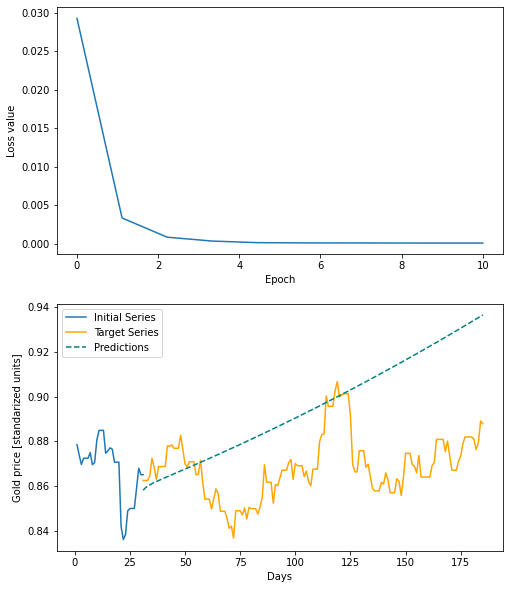

In [23]:
# Check the training effects
predict_and_plot(test_X, test_y, model)

In [24]:
# Train model with different number of cell units
model1 = fit_LSTM(train_X, train_y, cell_units=256, epochs=10)
model1[0].summary()

Epoch 1/10
12/12 [==============================] - 2s 69ms/step - loss: 0.0236
Epoch 2/10
12/12 [==============================] - 1s 75ms/step - loss: 0.0025
Epoch 3/10
12/12 [==============================] - 1s 74ms/step - loss: 6.2981e-04
Epoch 4/10
12/12 [==============================] - 1s 64ms/step - loss: 2.6399e-04
Epoch 5/10
12/12 [==============================] - 1s 59ms/step - loss: 9.4443e-05
Epoch 6/10
12/12 [==============================] - 1s 62ms/step - loss: 5.5611e-05
Epoch 7/10
12/12 [==============================] - 1s 59ms/step - loss: 4.6813e-05
Epoch 8/10
12/12 [==============================] - 1s 60ms/step - loss: 4.4692e-05
Epoch 9/10
12/12 [==============================] - 1s 59ms/step - loss: 4.4591e-05
Epoch 10/10
12/12 [==============================] - 1s 62ms/step - loss: 4.5265e-05
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM

start range:  range(1, 32)
predict range:  range(31, 186)


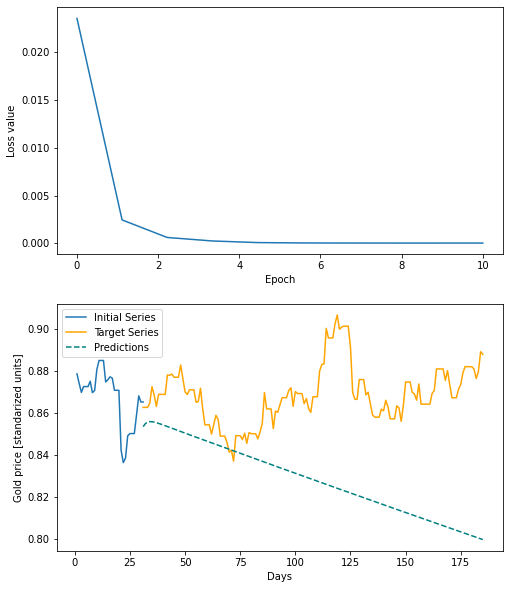

In [25]:
# Check the training effects
predict_and_plot(test_X, test_y, model1)

In [26]:
# Can we get better results if we increase a number of cells even more?
model2 = fit_LSTM(train_X, train_y, cell_units=512, epochs=10)
model2[0].summary()

Epoch 1/10
12/12 [==============================] - 3s 165ms/step - loss: 0.0172
Epoch 2/10
12/12 [==============================] - 2s 167ms/step - loss: 0.0012
Epoch 3/10
12/12 [==============================] - 2s 174ms/step - loss: 3.8963e-04
Epoch 4/10
12/12 [==============================] - 2s 183ms/step - loss: 1.4256e-04
Epoch 5/10
12/12 [==============================] - 2s 170ms/step - loss: 8.2119e-05
Epoch 6/10
12/12 [==============================] - 2s 171ms/step - loss: 5.7837e-05
Epoch 7/10
12/12 [==============================] - 2s 185ms/step - loss: 4.4164e-05
Epoch 8/10
12/12 [==============================] - 2s 169ms/step - loss: 3.8445e-05
Epoch 9/10
12/12 [==============================] - 2s 170ms/step - loss: 3.7930e-05
Epoch 10/10
12/12 [==============================] - 2s 169ms/step - loss: 3.8553e-05
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ls

start range:  range(1, 32)
predict range:  range(31, 186)


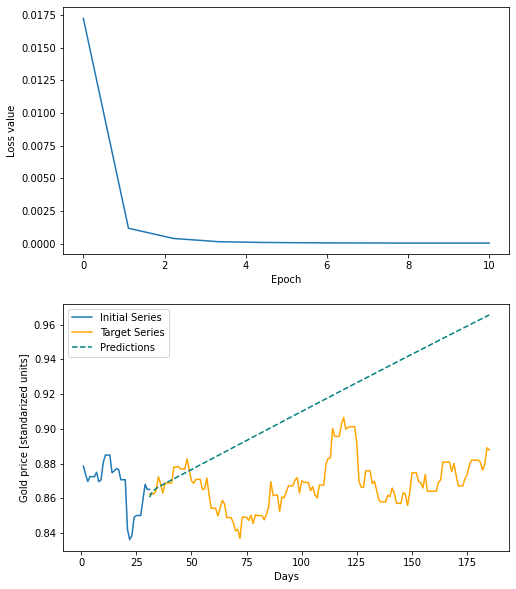

In [27]:
# Check the training effects
predict_and_plot(test_X, test_y, model2)

In [28]:
# And more unit cells
model3 = fit_LSTM(train_X, train_y, cell_units=1024, epochs=10)
model3[0].summary()

Epoch 1/10
12/12 [==============================] - 8s 556ms/step - loss: 0.1079
Epoch 2/10
12/12 [==============================] - 7s 619ms/step - loss: 0.0179
Epoch 3/10
12/12 [==============================] - 7s 610ms/step - loss: 0.0061
Epoch 4/10
12/12 [==============================] - 7s 561ms/step - loss: 0.0016
Epoch 5/10
12/12 [==============================] - 6s 529ms/step - loss: 4.0085e-04
Epoch 6/10
12/12 [==============================] - 6s 535ms/step - loss: 1.3628e-04
Epoch 7/10
12/12 [==============================] - 7s 543ms/step - loss: 9.0997e-05
Epoch 8/10
12/12 [==============================] - 6s 537ms/step - loss: 7.3115e-05
Epoch 9/10
12/12 [==============================] - 7s 544ms/step - loss: 6.5838e-05
Epoch 10/10
12/12 [==============================] - 7s 545ms/step - loss: 6.6603e-05
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LS

start range:  range(1, 32)
predict range:  range(31, 186)


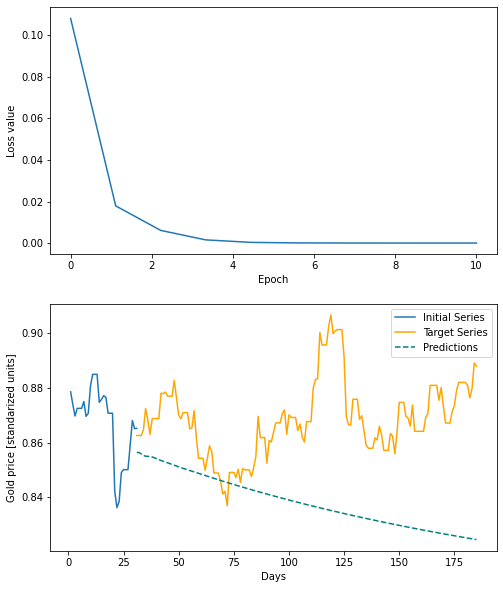

In [29]:
# Training results
predict_and_plot(test_X, test_y, model3)

In [30]:
model4 = fit_LSTM(train_X, train_y, cell_units=2048, epochs=10)
model4[0].summary()

Epoch 1/10
12/12 [==============================] - 22s 2s/step - loss: 0.0581
Epoch 2/10
12/12 [==============================] - 23s 2s/step - loss: 0.0238
Epoch 3/10
12/12 [==============================] - 21s 2s/step - loss: 0.0049
Epoch 4/10
12/12 [==============================] - 22s 2s/step - loss: 0.0011
Epoch 5/10
12/12 [==============================] - 22s 2s/step - loss: 2.8817e-04
Epoch 6/10
12/12 [==============================] - 20s 2s/step - loss: 1.2204e-04
Epoch 7/10
12/12 [==============================] - 21s 2s/step - loss: 7.8635e-05
Epoch 8/10
12/12 [==============================] - 20s 2s/step - loss: 5.5248e-05
Epoch 9/10
12/12 [==============================] - 20s 2s/step - loss: 4.7919e-05
Epoch 10/10
12/12 [==============================] - 20s 2s/step - loss: 4.7290e-05
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (N

start range:  range(1, 32)
predict range:  range(31, 186)


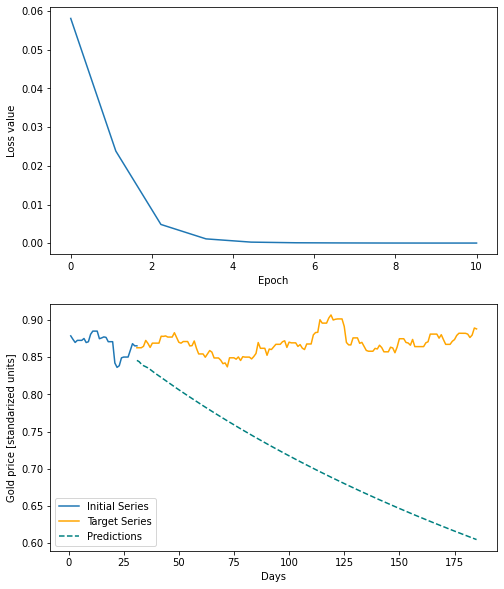

In [31]:
# Results
predict_and_plot(test_X, test_y, model4)

In [32]:
model5 = fit_LSTM(train_X, train_y, cell_units=1024, epochs=10, dropout=0.2)
model5[0].summary()

Epoch 1/10
12/12 [==============================] - 7s 541ms/step - loss: 0.0955
Epoch 2/10
12/12 [==============================] - 6s 533ms/step - loss: 0.0171
Epoch 3/10
12/12 [==============================] - 6s 537ms/step - loss: 0.0054
Epoch 4/10
12/12 [==============================] - 7s 541ms/step - loss: 0.0013
Epoch 5/10
12/12 [==============================] - 7s 541ms/step - loss: 4.4015e-04
Epoch 6/10
12/12 [==============================] - 7s 540ms/step - loss: 2.3771e-04
Epoch 7/10
12/12 [==============================] - 7s 545ms/step - loss: 1.2635e-04
Epoch 8/10
12/12 [==============================] - 7s 551ms/step - loss: 7.0056e-05
Epoch 9/10
12/12 [==============================] - 7s 543ms/step - loss: 6.8148e-05
Epoch 10/10
12/12 [==============================] - 7s 545ms/step - loss: 5.7185e-05
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LS

start range:  range(1, 32)
predict range:  range(31, 186)


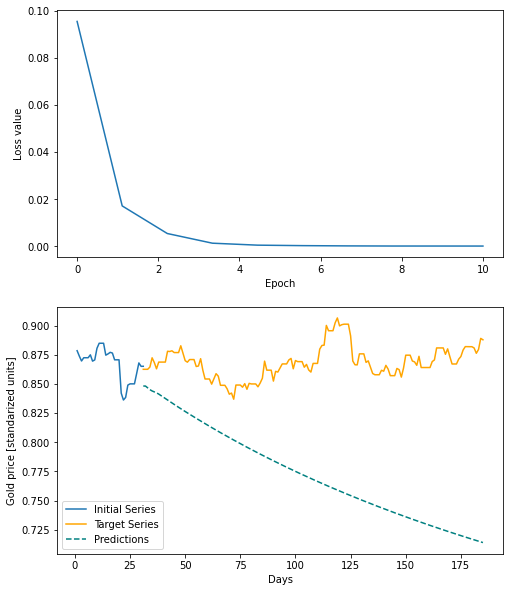

In [33]:
predict_and_plot(test_X, test_y, model5)

In [34]:
model6 = fit_LSTM(train_X, train_y, cell_units=2048, epochs=10, dropout=0.2)
model6[0].summary()

Epoch 1/10
12/12 [==============================] - 21s 2s/step - loss: 0.0748
Epoch 2/10
12/12 [==============================] - 21s 2s/step - loss: 0.0484
Epoch 3/10
12/12 [==============================] - 20s 2s/step - loss: 0.0269
Epoch 4/10
12/12 [==============================] - 20s 2s/step - loss: 0.0066
Epoch 5/10
12/12 [==============================] - 20s 2s/step - loss: 0.0011
Epoch 6/10
12/12 [==============================] - 21s 2s/step - loss: 2.5122e-04
Epoch 7/10
12/12 [==============================] - 21s 2s/step - loss: 1.3354e-04
Epoch 8/10
12/12 [==============================] - 20s 2s/step - loss: 6.5470e-05
Epoch 9/10
12/12 [==============================] - 20s 2s/step - loss: 5.9484e-05
Epoch 10/10
12/12 [==============================] - 20s 2s/step - loss: 5.6514e-05
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None,

start range:  range(1, 32)
predict range:  range(31, 186)


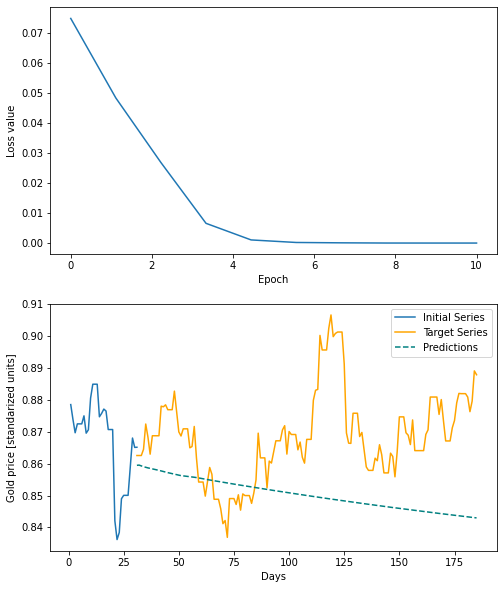

In [35]:
predict_and_plot(test_X, test_y, model6)

In [36]:
model7 = fit_LSTM(train_X, train_y, cell_units=4096, epochs=10, dropout=0.2)
model7[0].summary()

Epoch 1/10
12/12 [==============================] - 86s 7s/step - loss: 0.1615
Epoch 2/10
12/12 [==============================] - 83s 7s/step - loss: 0.0076
Epoch 3/10
12/12 [==============================] - 80s 7s/step - loss: 0.0013
Epoch 4/10
12/12 [==============================] - 83s 7s/step - loss: 5.4787e-04
Epoch 5/10
12/12 [==============================] - 83s 7s/step - loss: 2.2822e-04
Epoch 6/10
12/12 [==============================] - 83s 7s/step - loss: 1.2161e-04
Epoch 7/10
12/12 [==============================] - 82s 7s/step - loss: 8.1146e-05
Epoch 8/10
12/12 [==============================] - 82s 7s/step - loss: 9.1076e-05
Epoch 9/10
12/12 [==============================] - 85s 7s/step - loss: 9.8565e-05
Epoch 10/10
12/12 [==============================] - 82s 7s/step - loss: 8.3105e-05
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)             

start range:  range(1, 32)
predict range:  range(31, 186)


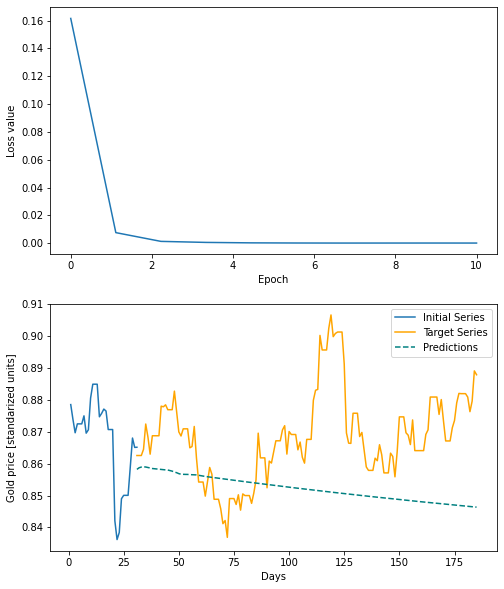

In [37]:
predict_and_plot(test_X, test_y, model7)

In [38]:
model8 = fit_LSTM(train_X, train_y, cell_units=2048, epochs=10, dropout=0.3)
model8[0].summary()

Epoch 1/10
12/12 [==============================] - 21s 2s/step - loss: 0.0645
Epoch 2/10
12/12 [==============================] - 20s 2s/step - loss: 0.0192
Epoch 3/10
12/12 [==============================] - 20s 2s/step - loss: 0.0036
Epoch 4/10
12/12 [==============================] - 20s 2s/step - loss: 0.0083
Epoch 5/10
12/12 [==============================] - 20s 2s/step - loss: 0.0030
Epoch 6/10
12/12 [==============================] - 21s 2s/step - loss: 6.0298e-04
Epoch 7/10
12/12 [==============================] - 21s 2s/step - loss: 2.3340e-04
Epoch 8/10
12/12 [==============================] - 20s 2s/step - loss: 9.2823e-05
Epoch 9/10
12/12 [==============================] - 20s 2s/step - loss: 9.5183e-05
Epoch 10/10
12/12 [==============================] - 20s 2s/step - loss: 6.8821e-05
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None,

start range:  range(1, 32)
predict range:  range(31, 186)


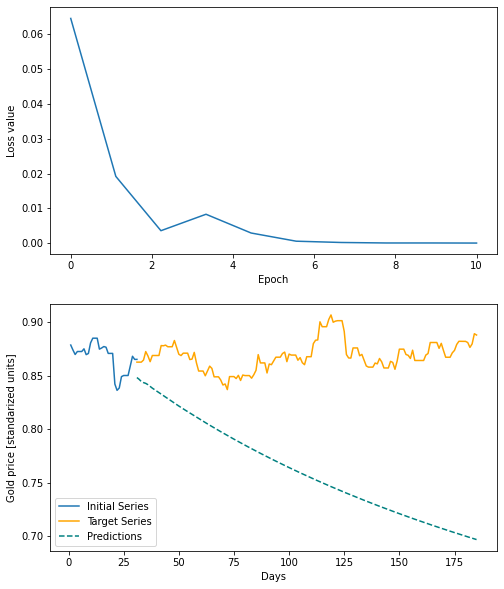

In [39]:
predict_and_plot(test_X, test_y, model8)

In [70]:
# Test loss value
# Split test data into samples

def test_loss(time_series, trainedmodel):
    """Prepare samples and compute MSE."""
    trainedmodel, _ = trainedmodel
    number_of_chunks = len(time_series) - 33
    X_test = []
    y_test = []
    for i in range(number_of_chunks):
        X_test.append(time_series[i : i + 31].reshape(1, -1, 1))
        y_test.append(time_series[i + 32])
    mse = 0
    for X, y in zip(X_test, y_test):
        y_pred = trainedmodel.predict(X)
        mse += (y - y_pred)**2
    return mse/number_of_chunks

In [79]:
# Model accuracies
loss = []
for i, m in enumerate([model, model1, model2, model3, model4, model5, model6, model7, model8]):
    value = test_loss(test_y, m)
    print(f"Model {i}", value)
    loss.append(value[0][0])


Model 0 [[0.00012877]]
Model 1 [[0.00012169]]
Model 2 [[0.00010221]]
Model 3 [[0.00015571]]
Model 4 [[0.00033845]]
Model 5 [[0.00025953]]
Model 6 [[0.00012659]]
Model 7 [[0.00014394]]
Model 8 [[0.00028573]]


<BarContainer object of 9 artists>

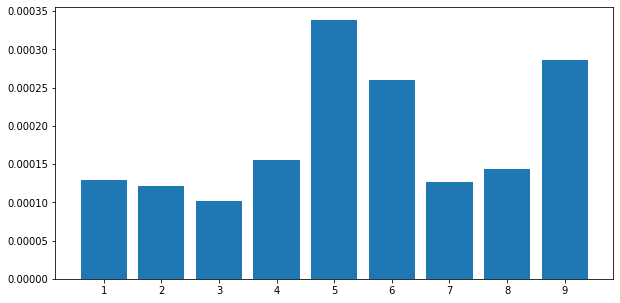

In [103]:
# Average mean square errors for each trained model
fig = plt.figure(figsize = (10, 5))
labels = [f"{i}" for i in range(1, 10)]
plt.bar(labels, loss)